In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from IPython.display import clear_output

from Alpha import Alpha

In [2]:
def cut_outliers(x, show=False):

    if show:
        # данные до обработки
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
        ax1.set_title('before formatting')
        ax1.plot(x)

    if cut_outliers:
        lower_bound = np.quantile(x, 0.005)
        upper_bound = np.quantile(x, 0.995)
        x[x < lower_bound] = lower_bound
        x[x > upper_bound] = upper_bound

    if show:
        # данные после обработки
        ax2.set_title('after formatting')
        ax2.plot(x)
        plt.show()

    return x

In [4]:
# EMPTY TICKERS OR TICKERS WITH GAP

TICKERS_WITH_GAP = ['AAVEDOWN-USDT', 'BNBDOWN-USDT', 'DOTDOWN-USDT', 'DREP-USDT',
       'ETHDOWN-USDT', 'LINKDOWN-USDT', 'LTCDOWN-USDT', 'LUNA-USDT',
       'SUSHIDOWN-USDT', 'SXPDOWN-USDT', 'TRXDOWN-USDT', 'UNIDOWN-USDT',
       'XLMDOWN-USDT', 'XTZDOWN-USDT', 'YFIDOWN-USDT']

BLOCK_TICKERS = []

close_df = pd.read_parquet(f"binance/close.parquet")
yy = close_df.dropna(how='all', axis=1)
BLOCK_TICKERS = list(set(close_df.columns).difference(set(yy.columns)))
BLOCK_TICKERS.extend(TICKERS_WITH_GAP)

In [ ]:
# READ DATA

all_files = os.listdir("binance/")
stationary_dataset = pd.DataFrame()


# WORKING WITH BAR COMPONENTS DATA

bar_components = ["vwap", "open", "high", "low"]
for bar_component in bar_components: 
    stationary_dataset[bar_component + "_pct"] = (
        pd.read_parquet(f"binance/{bar_component}.parquet")
        .drop(BLOCK_TICKERS, axis=1)
        .pct_change(fill_method=None)
        .ffill()
        .stack())
    all_files.remove(f"{bar_component}.parquet")

print("bar", stationary_dataset.isna().sum().sum())


# WORKING WITH OTHER DATA

all_files.remove(f"close.parquet") # target later

dataset = pd.DataFrame()
for filename in tqdm(all_files):
    dataset[filename.split('.')[0]] = (
        pd.read_parquet(f"binance/{filename}")
        .drop(BLOCK_TICKERS, axis=1)
        .ffill()
        .stack())


# ORDER BOOK DATA

stationary_dataset["volume"] = dataset["sell_volume"] / dataset["buy_volume"]
stationary_dataset["count"] = dataset["sell_count"] / dataset["buy_count"]

stationary_dataset["best_bid_ask"] = dataset["best_bid"] / dataset["best_ask"]
stationary_dataset["best_bid_ask_size"] = dataset["best_bid_size"] / dataset["best_ask_size"]
stationary_dataset["high_bid_low_ask"] = dataset["bid_high"] / dataset["ask_low"]
stationary_dataset["low_bid_high_ask"] = dataset["bid_low"] / dataset["ask_high"]


for column_name in dataset.columns:

    # MARKET ORDER DATA

    if "mo" in column_name:
        if "hh" in column_name: 
            stationary_dataset[column_name] = dataset[column_name]
        elif "1" in column_name:
            suffix = column_name.split("1")[1]
            print(dataset[f"mo0{suffix}"].isna().sum().sum())
            print(dataset[f"mo1{suffix}"].isna().sum().sum())
            stationary_dataset[f"mo{suffix}"] = ((
                dataset[f"mo1{suffix}"] / (dataset[f"mo0{suffix}"] + dataset[f"mo1{suffix}"]))
                .where((dataset[f"mo1{suffix}"] > 0) & (dataset[f"mo0{suffix}"] > 0), 0))

    # WITH QUANTILE DATA

    elif column_name.startswith("bid") and column_name.endswith("size"):
        quantile = column_name.split('_')[1]
        stationary_dataset[f"quantile_{quantile}_size"] = ((
            dataset[f"bid_{quantile}_size"] / (dataset[f"ask_{quantile}_size"] + dataset[f"bid_{quantile}_size"]))
            .where((dataset[f"ask_{quantile}_size"] > 0) & (dataset[f"bid_{quantile}_size"] > 0), 0))
    elif column_name.startswith("bid") and column_name.endswith("vwap"):
        quantile = column_name.split('_')[1]
        stationary_dataset[f"quantile_{quantile}_vwap"] = ((
            dataset[f"bid_{quantile}_vwap"] / (dataset[f"ask_{quantile}_vwap"] + dataset[f"bid_{quantile}_vwap"]))
            .where((dataset[f"ask_{quantile}_vwap"] > 0) & (dataset[f"bid_{quantile}_vwap"] > 0), 0))


stationary_dataset = stationary_dataset.sort_index(axis=1)


# ADD TARGET 

stationary_dataset["target"] = (
    pd.read_parquet(f"binance/close.parquet")
    .drop(BLOCK_TICKERS, axis=1)
    .pct_change(fill_method=None)
    .shift(-1)
    .ffill()
    .stack())


# CUT OUTLIARS

for column_name in stationary_dataset.columns:
    stationary_dataset[column_name] = cut_outliers(stationary_dataset[column_name].values)

In [6]:
# SAVE DATASET
stationary_dataset.to_parquet("stationary_dataset.gzip", compression='gzip')

LSTM NEURAL NETWORK

In [7]:
stationary_dataset = pd.read_parquet("stationary_dataset.gzip")
idx = pd.IndexSlice

params = dict(
    input_dim = stationary_dataset.shape[1]-1,
    hidden_dim = (stationary_dataset.shape[1]-1) // 4,
    output_dim = 1,
    batch_size = 64,
    learning_rate = 1e-3,
    epochs = 3
)

In [5]:
# FILTER TICKERS

def filter_tickers(dataset: pd.DataFrame):

    dataset = dataset.ffill(limit=8).dropna(how='all', axis=1)

    number_of_nan = dataset.isna().sum(axis=0)
    nan_mask = number_of_nan == 0
    dataset = dataset.loc[:, nan_mask]

    filtered_tickers = pd.Series(dataset.columns)
    return filtered_tickers

In [8]:
# MODEL DATA STRUCTURE

class lstm_dataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data[:, :-1], dtype=torch.float32)
        self.label = torch.tensor(data[:, -1], dtype=torch.float32).unsqueeze_(1)
        self.n_samples = data.shape[0] 

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
# LSTM NEURAL NETWORK

class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [9]:
def train_model(model, criterion, optimizer, train_loader, epochs):
    train_losses = []
    
    for _ in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        
        for X, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)

    print("Train Loss : {:.8f}".format(torch.tensor(train_losses).mean()))


def test_model(model, criterion, test_loader):
    test_losses, predicted_return = [], []
    
    with torch.no_grad():
        test_loss = 0

        for X, y in test_loader:
            y_pred = model(X)
            predicted_return.extend(y_pred.detach().numpy().flatten())
            loss = criterion(y_pred, y)
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
    
    print("Test Loss : {:.8f}".format(torch.tensor(test_losses).mean()))
    return predicted_return
    
    

In [12]:
# TRAINING & PREDICTION

date_current = pd.Timestamp("2020-06")
date_end = pd.Timestamp("2022-12")
correction =  pd.Timedelta(30, unit="m")
month_step = pd.DateOffset(months=1)

predicted_returns = []

while date_current <= date_end:

    lstm_model = LSTM_Model(params['input_dim'], params['hidden_dim'], params['output_dim'])
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=params['learning_rate'])
    
    train_test_split = date_current + month_step * 3
    
    train_dataset = lstm_dataset(stationary_dataset.loc[idx[date_current : train_test_split - correction, :], :].values)
    test_dataset = lstm_dataset(stationary_dataset.loc[idx[train_test_split : train_test_split + month_step - correction, :], :].values)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])

    train_model(lstm_model, criterion, optimizer, train_loader, params['epochs'])
    predicted_return = test_model(lstm_model, criterion, test_loader)
    predicted_returns.append(pd.Series(np.array(predicted_return).flatten(), index=stationary_dataset[train_test_split : train_test_split + month_step - correction].index))

    date_current = date_current + month_step
    


100%|██████████| 3/3 [01:08<00:00, 22.95s/it]


Train Loss : 0.00015098
Test Loss : 0.00015633


100%|██████████| 3/3 [01:18<00:00, 26.04s/it]


Train Loss : 0.00015285
Test Loss : 0.00007674


100%|██████████| 3/3 [01:28<00:00, 29.36s/it]


Train Loss : 0.00016066
Test Loss : 0.00012405


100%|██████████| 3/3 [19:40<00:00, 393.50s/it]


Train Loss : 0.00031406
Test Loss : 0.00010736


100%|██████████| 3/3 [01:50<00:00, 36.95s/it]


Train Loss : 0.00011145
Test Loss : 0.00020916


100%|██████████| 3/3 [01:55<00:00, 38.60s/it]


Train Loss : 0.00020755
Test Loss : 0.00038614


100%|██████████| 3/3 [01:58<00:00, 39.43s/it]


Train Loss : 0.00021232
Test Loss : 0.00015005


100%|██████████| 3/3 [02:16<00:00, 45.35s/it]


Train Loss : 0.00035190
Test Loss : 0.00014312


100%|██████████| 3/3 [02:39<00:00, 53.08s/it]


Train Loss : 0.00018157
Test Loss : 0.00019281


100%|██████████| 3/3 [02:55<00:00, 58.57s/it]


Train Loss : 0.00018859
Test Loss : 0.00020554


100%|██████████| 3/3 [03:01<00:00, 60.51s/it]


Train Loss : 0.00022248
Test Loss : 0.00012600


100%|██████████| 3/3 [03:16<00:00, 65.43s/it]


Train Loss : 0.00020165
Test Loss : 0.00012938


100%|██████████| 3/3 [03:31<00:00, 70.39s/it]


Train Loss : 0.00016065
Test Loss : 0.00015757


100%|██████████| 3/3 [03:42<00:00, 74.21s/it]


Train Loss : 0.00015382
Test Loss : 0.00010010


100%|██████████| 3/3 [03:51<00:00, 77.04s/it]


Train Loss : 0.00014302
Test Loss : 0.00011750


100%|██████████| 3/3 [04:00<00:00, 80.29s/it]


Train Loss : 0.00016321
Test Loss : 0.00011979


100%|██████████| 3/3 [04:14<00:00, 84.90s/it]


Train Loss : 0.00012923
Test Loss : 0.00010379


100%|██████████| 3/3 [04:23<00:00, 87.94s/it]


Train Loss : 0.00013785
Test Loss : 0.00009523


100%|██████████| 3/3 [04:28<00:00, 89.64s/it]


Train Loss : 0.00012745
Test Loss : 0.00014585


100%|██████████| 3/3 [04:33<00:00, 91.15s/it]


Train Loss : 0.00012355
Test Loss : 0.00007372


100%|██████████| 3/3 [04:37<00:00, 92.59s/it]


Train Loss : 0.00012214
Test Loss : 0.00080212


100%|██████████| 3/3 [04:48<00:00, 96.26s/it]


Train Loss : 0.00013231
Test Loss : 0.00013523


100%|██████████| 3/3 [04:49<00:00, 96.41s/it]


Train Loss : 0.00014533
Test Loss : 0.00014601


100%|██████████| 3/3 [04:54<00:00, 98.22s/it]


Train Loss : 0.00017568
Test Loss : 0.00007342


100%|██████████| 3/3 [04:55<00:00, 98.42s/it]


Train Loss : 0.00011247
Test Loss : 0.00007769


100%|██████████| 3/3 [05:08<00:00, 102.90s/it]


Train Loss : 0.00008882
Test Loss : 0.00005644


100%|██████████| 3/3 [05:15<00:00, 105.22s/it]


Train Loss : 0.00006591
Test Loss : 0.00010694


100%|██████████| 3/3 [05:01<00:00, 100.60s/it]


Train Loss : 0.00009170
Test Loss : 0.00003976


  0%|          | 0/3 [01:08<?, ?it/s]


KeyboardInterrupt: 

In [19]:
LSTM_WEIGHTS = pd.concat(predicted_returns).reset_index().pivot(index="level_0", columns="level_1", values = 0)
LSTM_WEIGHTS.to_parquet("raw_alpha_weights/LSTM_WEIGHTS.gzip", compression='gzip')
LSTM_WEIGHTS

level_1,1INCH-USDT,1INCHDOWN-USDT,1INCHUP-USDT,AAVE-USDT,AAVEUP-USDT,ACA-USDT,ACH-USDT,ACM-USDT,ADA-USDT,ADADOWN-USDT,...,XVS-USDT,XZC-USDT,YFI-USDT,YFII-USDT,YFIUP-USDT,YGG-USDT,ZEC-USDT,ZEN-USDT,ZIL-USDT,ZRX-USDT
level_0,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001059,NaN,...,NaN,-0.001155,-0.000942,NaN,NaN,NaN,-0.001049,NaN,-0.000663,-0.000529
2020-09-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000976,NaN,...,NaN,-0.000400,-0.001247,NaN,NaN,NaN,-0.000875,NaN,-0.000645,-0.001172
2020-09-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000429,NaN,...,NaN,-0.000443,-0.000477,NaN,NaN,NaN,-0.000430,NaN,-0.000540,-0.001051
2020-09-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000833,NaN,...,NaN,-0.000836,-0.000507,NaN,NaN,NaN,-0.000831,NaN,-0.000718,-0.001049
2020-09-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000943,NaN,...,NaN,-0.000607,-0.000506,NaN,NaN,NaN,-0.001327,NaN,-0.000603,-0.001140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:30:00,0.000254,0.010873,-0.000875,0.000244,0.023391,-0.001503,-0.000487,-0.000143,-0.000115,0.000361,...,-0.000633,0.015119,-0.000611,0.000022,0.000020,0.000240,-0.000221,0.002109,0.000443,0.000056
2022-12-31 22:00:00,0.000487,0.011254,-0.000541,-0.000101,0.023811,0.000577,-0.001418,-0.001146,-0.001385,-0.000237,...,0.000630,0.015631,0.000478,0.000540,0.000380,0.000414,0.000340,0.000589,0.000106,0.000434
2022-12-31 22:30:00,0.000625,0.011446,-0.000622,0.000129,0.023589,0.000077,0.000333,-0.001536,-0.000163,-0.000712,...,-0.000268,0.014810,0.001378,0.001506,0.000145,0.000161,-0.000067,0.000251,0.000301,0.000195


Стратегия LSTM

Annualized Sharpe Ratio = 9.05
Daily tvr = 500.32%
Annual return = 161.27%
Max Drawdown = -17.17%
Margin = 0.0 bp



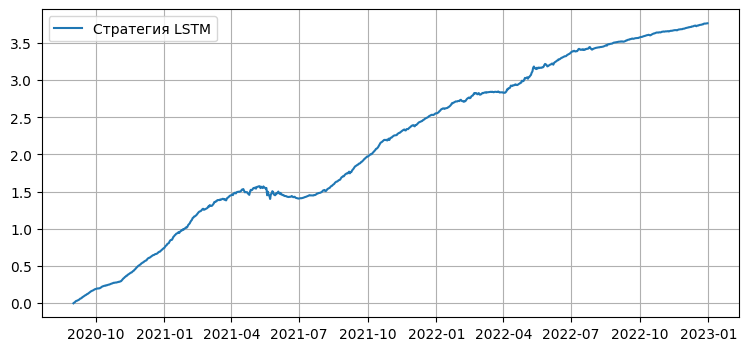

In [10]:
LSTM_WEIGHTS = pd.read_parquet("raw_alpha_weights/LSTM_WEIGHTS.gzip")
close_df = pd.read_parquet("binance/close.parquet")["2020-09-01":].drop(BLOCK_TICKERS, axis=1)
vwap_df = pd.read_parquet("binance/vwap.parquet")["2020-09-01":].drop(BLOCK_TICKERS, axis=1)

LSTM_ALPHA = Alpha(LSTM_WEIGHTS, close_df, vwap_df)
LSTM_ALPHA.truncate_and_normalize(0.05)
LSTM_ALPHA.decay(6)

plt.figure(figsize=(9, 4))
LSTM_ALPHA.backtest(display=True, label="Стратегия LSTM")
plt.legend()
plt.grid()
plt.show()